In [1]:
import matplotlib.colors
import pandas as pd

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from autorocks.data.loader.all_models_result_aggregator import create_all_models_comparison_dataset
from autorocks.dir_struct import RootDir
from autorocks.envs.gem5.benchmarks.benchmark_tasks import MachSuiteTask

# output_location = "/Users/salabed/workspace/latex_writings/papers/mlsys21_autobo/figs"
output_location = "/home/salabed/workspace/latex/papers/mlsys21_autobo/figs"
output_format = "svg"  # pdf
if output_format == "svg":
    output_location = f"{output_location}/svg/"
save_res = False

exp_name = str(MachSuiteTask.STENCIL_3D)
exp_dir = RootDir.parents[1] / f"local_execution/gem5mobo/{exp_name}/20_params/100_iter"
model_comparison_data = create_all_models_comparison_dataset(exp_dir)

Creating: /home/salabed/workspace/autorocks/local_execution/gem5mobo/stencil_stencil3d/20_params/100_iter/compare_all_models_training_time.csv
Creating: /home/salabed/workspace/autorocks/local_execution/gem5mobo/stencil_stencil3d/20_params/100_iter/compare_all_models_perf_step.csv
Creating: /home/salabed/workspace/autorocks/local_execution/gem5mobo/stencil_stencil3d/20_params/100_iter/compare_all_models_params.csv


In [4]:
import autorocks.viz.viz as viz

model_comparison_data_c = viz.unify_model_name(model_comparison_data)
color_palette = viz.create_color_palette_df(
    model_comparison_data_c.system_performance, ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
)

pdp = (
    model_comparison_data_c.system_performance["bench_stats.avg_power"]
    * model_comparison_data_c.system_performance["bench_stats.cycle"]
)
# pdp = self.avg_power * self.cycle
import numpy as np

edp = np.log(model_comparison_data_c.system_performance["bench_stats.cycle"].values * pdp.values)
# pdp
model_comparison_data_c.system_performance["bench_stats.pdp"] = np.log(pdp)

model_comparison_data_c.system_performance["bench_stats.edp"] = edp

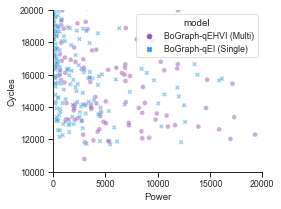

In [5]:
import seaborn as sns
from matplotlib import colors, pyplot as plt

plt.rcParams["svg.fonttype"] = "none"
plt.rcParams["font.family"] = "Arial"

plt.style.use("ggplot")
sns.set_theme(style="ticks", rc={"axes.spines.right": False, "axes.spines.top": False})
sns.set_context("paper")  # , font_scale=1.5, rc={"lines.linewidth": 1.5})
plt.rc("font", family="sans-serif", serif="Arial")

df = model_comparison_data_c.system_performance.copy()
cmap = colors.LinearSegmentedColormap.from_list("incr_alpha", [(0, (*colors.to_rgb("C0"), 0)), (1, "C0")])
fig, ax = plt.subplots(figsize=(4, 3))

MODEL_NAME_MAPPING = {"BoGraph": "BoGraph-qEI (Single)", "MoBO": "BoGraph-qEHVI (Multi)"}
df["model"] = df["model"].map(MODEL_NAME_MAPPING).fillna(df["model"])
color_palette = viz.create_color_palette_df(df, ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"])
# df["bench_stats.cycle"] =np.log(df["bench_stats.cycle"])
# df["bench_stats.avg_power"] =np.log(df["bench_stats.avg_power"])
import matplotlib

ax = sns.scatterplot(
    data=df,
    x="bench_stats.avg_power",
    y="bench_stats.cycle",
    hue="model",
    style="model",
    norm=matplotlib.colors.LogNorm(),
    # alpha={"MoBO": 0.5, "BoGraph": 1}
    # cmap=cmap,
    alpha=0.5,
    palette=color_palette,
    ax=ax,
)
ax.set(xlabel="Power", ylabel="Cycles", xlim=[0, 20000], ylim=[10000, 20000])

# plt.plot(df['bench_stats.avg_power'],
#          df['bench_stats.cycle'],
#          '--', label='Pareto frontier', alpha=0.5)

fig.tight_layout()
if save_res:
    fig.savefig(
        f"{output_location}/{exp_name}_mobo.{output_format}", bbox_inches="tight", format=f"{output_format}", dpi=600
    )
# ax.set_legend()

In [14]:
from botorch.utils.multi_objective import is_non_dominated
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
y = torch.tensor(df[["bench_stats.cycle", "bench_stats.avg_power"]].values, device=device) * -1
pareto_frontier = is_non_dominated(y)

[Text(0.5, 0, 'Power'),
 Text(0, 0.5, 'Cycles'),
 (0.0, 6000.0),
 (10000.0, 18000.0)]

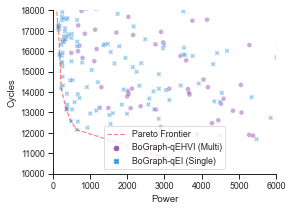

In [29]:
fig, ax = plt.subplots(figsize=(4, 3))

frontier_points = pareto_frontier.cpu().numpy()
ax = sns.scatterplot(
    data=df,
    x="bench_stats.avg_power",
    y="bench_stats.cycle",
    hue="model",
    style="model",
    norm=matplotlib.colors.LogNorm(),
    # alpha={"MoBO": 0.5, "BoGraph": 1}
    # cmap=cmap,
    alpha=0.5,
    palette=color_palette,
    ax=ax,
)
sns.lineplot(
    data=df[frontier_points],
    x="bench_stats.avg_power",
    y="bench_stats.cycle",
    linestyle="--",
    label="Pareto Frontier",
    alpha=0.5,
    ax=ax,
    color="red",
)
ax.set(xlabel="Power", ylabel="Cycles", xlim=[0, 6000], ylim=[10000, 18000])

# Pareto for each front

In [30]:
df

,step,bench_stats.cycle,bench_stats.total_area,bench_stats.avg_power,bench_stats.idle_fu_cycles,bench_stats.avg_fu_power,bench_stats.avg_fu_dynamic_power,bench_stats.avg_fu_leakage_power,bench_stats.avg_mem_power,bench_stats.avg_mem_dynamic_power,...,bench_stats.num_double_precision_fp_multipliers,bench_stats.num_double_precision_fp_adders,bench_stats.num_trigonometric_units,bench_stats.num_bitwise_operators,bench_stats.num_multipliers,bench_stats.num_shifters,iteration,model,bench_stats.pdp,bench_stats.edp
0,1,46711.0,4.527260e+08,2099.170,41173.0,3.51310,1.754500,1.75861,2095.660,1631.780,...,0,0,0,30.0,0,31.0,0,BoGraph-qEHVI (Multi),18.401032,29.152767
1,2,65814.0,9.149630e+09,30837.100,59383.0,2.04075,0.999409,1.04134,30835.100,1910.410,...,0,0,0,30.0,0,31.0,0,BoGraph-qEHVI (Multi),21.431062,32.525650
2,3,12613.0,3.239470e+08,4447.080,10554.0,10.27750,6.552370,3.72509,4436.800,4043.620,...,0,0,0,30.0,0,31.0,0,BoGraph-qEHVI (Multi),17.842486,27.284970
3,4,81766.0,2.351050e+09,6698.240,75283.0,2.59212,1.418900,1.17322,6695.650,4517.760,...,0,0,0,30.0,0,31.0,0,BoGraph-qEHVI (Multi),20.121217,31.432834
4,5,12494.0,2.024470e+09,8465.270,10535.0,5.92791,2.299890,3.62803,8459.350,3814.190,...,0,0,0,30.0,0,31.0,0,BoGraph-qEHVI (Multi),18.476731,27.909735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,96,14582.0,6.018630e+07,527.203,11279.0,6.75014,3.612720,3.13742,520.453,295.825,...,0,0,0,30.0,0,31.0,2,BoGraph-qEI (Single),15.855129,25.442672
596,97,13951.0,7.575140e+08,4541.280,11494.0,7.94823,4.728010,3.22022,4533.330,2465.290,...,0,0,0,30.0,0,31.0,2,BoGraph-qEI (Single),17.964271,27.507577
597,98,13708.0,9.823970e+07,713.874,11035.0,7.15705,3.837240,3.31981,706.717,454.635,...,0,0,0,30.0,0,31.0,2,BoGraph-qEI (Single),16.096441,25.622176
598,99,76308.0,3.551510e+08,974.380,72395.0,2.25308,0.670781,1.58230,972.127,313.528,...,0,0,0,30.0,0,31.0,2,BoGraph-qEI (Single),18.124334,29.366867


In [45]:
y_qehvi = (
    torch.tensor(
        df[df["model"] == "BoGraph-qEHVI (Multi)"][["bench_stats.cycle", "bench_stats.avg_power"]].values, device=device
    )
    * -1
)
y_qei = (
    torch.tensor(
        df[df["model"] == "BoGraph-qEI (Single)"][["bench_stats.cycle", "bench_stats.avg_power"]].values, device=device
    )
    * -1
)
pareto_frontier_qehvi = is_non_dominated(y_qehvi).cpu().numpy()
pareto_frontier_qei = is_non_dominated(y_qei).cpu().numpy()

In [91]:
dominated_points = pd.concat(
    [
        df[df["model"] == "BoGraph-qEHVI (Multi)"][np.invert(pareto_frontier_qehvi)],
        (df[df["model"] == "BoGraph-qEI (Single)"][np.invert(pareto_frontier_qei)]),
    ]
)

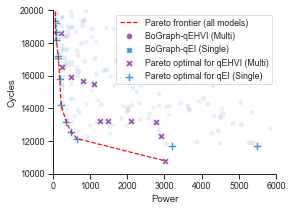

In [107]:
fig, ax = plt.subplots(figsize=(4, 3))

frontier_points = pareto_frontier.cpu().numpy()

ax = sns.scatterplot(
    data=dominated_points,
    x="bench_stats.avg_power",
    y="bench_stats.cycle",
    hue="model",
    style="model",
    norm=matplotlib.colors.LogNorm(),
    # alpha={"MoBO": 0.5, "BoGraph": 1}
    # cmap=cmap,
    alpha=0.15,
    palette=color_palette,
    ax=ax,
)

ax = sns.scatterplot(
    data=df[df["model"] == "BoGraph-qEHVI (Multi)"][pareto_frontier_qehvi],
    x="bench_stats.avg_power",
    y="bench_stats.cycle",
    # alpha={"MoBO": 0.5, "BoGraph": 1}
    # cmap=cmap,
    # alpha=0.5,
    color=color_palette["BoGraph-qEHVI (Multi)"],
    label="Pareto optimal for qEHVI (Multi)",
    ax=ax,
    s=50,
    marker="X",
)
ax = sns.scatterplot(
    data=df[df["model"] == "BoGraph-qEI (Single)"][pareto_frontier_qei],
    x="bench_stats.avg_power",
    y="bench_stats.cycle",
    # alpha={"MoBO": 0.5, "BoGraph": 1}
    # cmap=cmap,
    # alpha=0.5,
    color=color_palette["BoGraph-qEI (Single)"],
    label="Pareto optimal for qEI (Single)",
    ax=ax,
    marker="P",
    s=50,
)
sns.lineplot(
    data=df[frontier_points],
    x="bench_stats.avg_power",
    y="bench_stats.cycle",
    linestyle="--",
    label="Pareto frontier (all models)",
    alpha=1,
    ax=ax,
    color="red",
)
ax.set(xlabel="Power", ylabel="Cycles", xlim=[0, 6000], ylim=[10000, 20000])

save_res = True
if save_res:
    fig.savefig(
        f"{output_location}/{exp_name}_mobo.{output_format}", bbox_inches="tight", format=f"{output_format}", dpi=600
    )

In [44]:
[pareto_frontier_qei]

[array([], dtype=bool)]

No handles with labels found to put in legend.


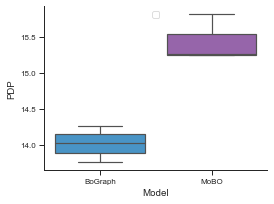

In [31]:
fig = viz.perf_boxplot(
    perf_df=model_comparison_data_c.system_performance,
    optimization_type=viz.OptimizationType.MINIMIZE,
    ylabel="PDP",
    comparison_col="bench_stats.pdp",
    model_palette_map=color_palette,
    # horizontal_line='Default'
)
if save_res:
    fig.savefig(
        f"{output_location}/{exp_name}_reduced_epd_perf.{output_format}",
        bbox_inches="tight",
        format=f"{output_format}",
        dpi=600,
    )
fig